## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [2]:
! pip install finance-datareader

In [3]:
import FinanceDataReader as fdr

In [4]:
stocks1 = fdr.StockListing('NASDAQ') # 나스닥 종목 코드

100%|██████████| 3691/3691 [00:28<00:00, 128.55it/s]


In [5]:
stocks1

,Symbol,Name,IndustryCode,Industry
0,AAPL,Apple Inc,57106020,전화 및 소형 장치
1,NVDA,NVIDIA Corp,57101010,반도체
2,MSFT,Microsoft Corp,57201020,소프트웨어
3,AMZN,Amazon.com Inc,53402010,백화점
4,META,Meta Platforms Inc,57201030,온라인 서비스
...,...,...,...,...
3686,DTSQR,DT Cloud Star Acquisition Rights,55601010,투자 지주 회사
3687,NEWTH,NewtekOne 8 625 Fixed Rate Senior Notes due 2029,55101050,기업 금융 서비스
3688,CLIK,Click Holdings Ltd,52203030,고용 서비스
3689,LPBBU,Launch Two Acquisition Units,55601010,투자 지주 회사


In [6]:
# 엔비디아(NVDA), 2021-01-01 ~ 2024-09-30 주가 데이터
nv = fdr.DataReader('NVDA', '2019-01-01', '2023-12-31')       ## '2021-01-01', '2024-09-30'
nv

,Open,High,Low,Close,Volume,Adj Close
2019-01-02,3.266000,3.462000,3.251250,3.405500,508752000,3.378322
2019-01-03,3.344750,3.379000,3.192250,3.199750,705552000,3.174216
2019-01-04,3.273500,3.443250,3.242500,3.404750,585620000,3.377578
2019-01-07,3.462500,3.622250,3.410750,3.585000,709160000,3.556390
2019-01-08,3.667250,3.669500,3.422500,3.495750,786016000,3.467852
...,...,...,...,...,...,...
2023-12-22,49.195000,49.382999,48.466999,48.830002,252507000,48.819527
2023-12-26,48.967999,49.599998,48.959999,49.278999,244200000,49.268425
2023-12-27,49.511002,49.680000,49.084999,49.417000,233648000,49.406395
2023-12-28,49.643002,49.883999,49.411999,49.521999,246587000,49.511375


In [7]:
## 예시 출력 ##

- Open (시가)
- High (고가)
- Low (저가)
- Close (종가) : 시장이 마감되기 전 마지막으로 거래된 주가
- Adj Close (수정 종가) : 해당 주식의 종가에 분할, 배당금 분배 등 주가에 영향을 미칠만한 기업의 활동을 반영한 후의 종가
- Volume (거래량)

1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [8]:
print(nv.isnull().sum())

Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64


1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [10]:
nv

,Open,High,Low,Close,Volume,Adj Close
2019-01-02,3.266000,3.462000,3.251250,3.405500,508752000,3.378322
2019-01-03,3.344750,3.379000,3.192250,3.199750,705552000,3.174216
2019-01-04,3.273500,3.443250,3.242500,3.404750,585620000,3.377578
2019-01-07,3.462500,3.622250,3.410750,3.585000,709160000,3.556390
2019-01-08,3.667250,3.669500,3.422500,3.495750,786016000,3.467852
...,...,...,...,...,...,...
2023-12-22,49.195000,49.382999,48.466999,48.830002,252507000,48.819527
2023-12-26,48.967999,49.599998,48.959999,49.278999,244200000,49.268425
2023-12-27,49.511002,49.680000,49.084999,49.417000,233648000,49.406395
2023-12-28,49.643002,49.883999,49.411999,49.521999,246587000,49.511375


In [11]:
# 이미 인덱스 설정, 시간 순으로 정렬되어 있으나 설정하는 코드:

# apl.set_index('Date', inplace=True)  # 컬럼을 인덱스로 지정하는 경우
nv.index.name = 'Date'

nv.sort_index(inplace=True)

In [12]:
nv

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,3.266000,3.462000,3.251250,3.405500,508752000,3.378322
2019-01-03,3.344750,3.379000,3.192250,3.199750,705552000,3.174216
2019-01-04,3.273500,3.443250,3.242500,3.404750,585620000,3.377578
2019-01-07,3.462500,3.622250,3.410750,3.585000,709160000,3.556390
2019-01-08,3.667250,3.669500,3.422500,3.495750,786016000,3.467852
...,...,...,...,...,...,...
2023-12-22,49.195000,49.382999,48.466999,48.830002,252507000,48.819527
2023-12-26,48.967999,49.599998,48.959999,49.278999,244200000,49.268425
2023-12-27,49.511002,49.680000,49.084999,49.417000,233648000,49.406395


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

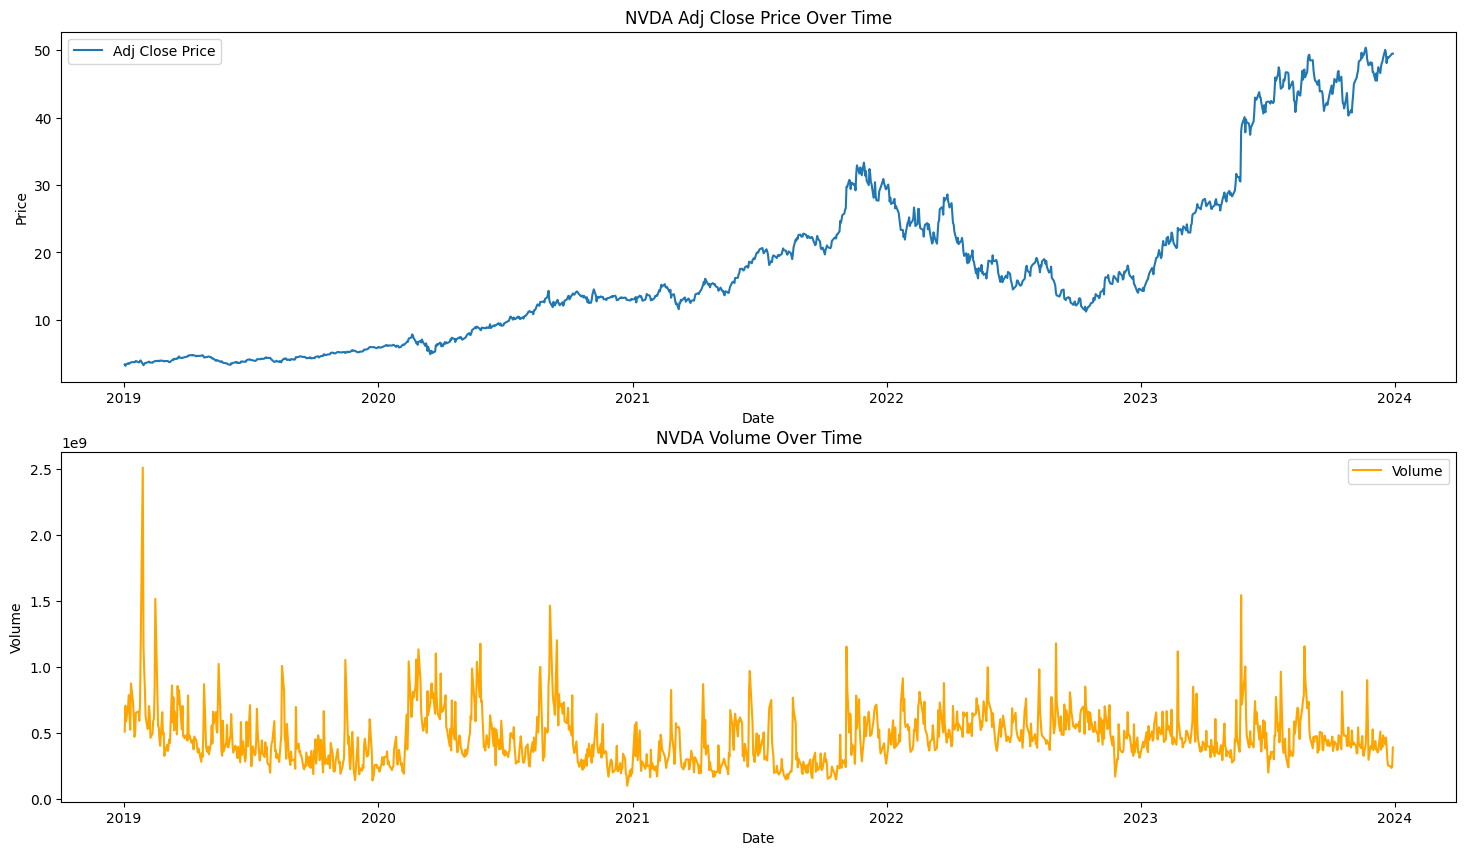

In [14]:
fig,axs = plt.subplots(2, 1, figsize=(18, 10))

axs[0].plot(nv.index, nv['Adj Close'])
axs[0].set_title('NVDA Adj Close Price Over Time')
axs[0].set(xlabel='Date', ylabel='Price')
axs[0].legend(['Adj Close Price'])

axs[1].plot(nv.index, nv['Volume'], color='orange')
axs[1].set_title('NVDA Volume Over Time')
axs[1].set(xlabel='Date', ylabel='Volume')
axs[1].legend(['Volume'])

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

- 엔비디아의 수정 종가는 팬데믹 당시 재택근무와 게임 산업 확장으로 주목을 받기 시작했고 잠시 외부 요인들로 인한 주가 하락세가 보였으나 2023년 이후 반도체 수요 증가와 AI산업 확산으로 급상승하여 유지되어 오고 있다.
- 거래량은 2019년 데이터 센터와 AI 수요 증가, 게이밍 GPU 출시가 성공적으로 이루어지면서 주가가 급등하여 조사 기간 중 최고치를 기록하기도 했고 이후 평균 거래량은 강한 수요와 변동성을 보인다.

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

[정상성이란?]

정상성이란 시계열 데이터가 (분산이 증가하거나 감소하는 등의) 통계적 특징의 변화 없이 추세나 계절성을 보이지 않을 때, 즉 과거,현재,미래의 분포가 같을 때 정상성을 띤다고 한다.
그래프 보며 시각적으로 판단하거나 검정을 통해 정상성을 판단한다.

[검정 방법]
- KPSS(Kwiatkowski-Phillips-Schmidt-Shin) 검정
- ADF(Augmented Dicky-Fuller) 검정

[중요성]

시계열 데이터가 정상성을 띠고 있어야 ARIMA 분석을 통해 미래 시계열 값을 예측할 수 있다. 시계열 데이터가 비정상성을 띠면 평균과 분산이 다르기 때문에 임의의 시점 t-1, t에서 얻은 모델은 t+1~t+n에서 사용할 수 없다. 즉 미래의 값을 예측할 수 없게 된다. (회귀분석이 아닌 다른 기법으로 예측할 시 정상성을 고려하지 않아도 된다.)

[비정상성을 정상성으로 만드는 방법]
1. 차분
2. 로그변환
3. 로그차분

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
# 수정 종가에 대한 데이터 추출한 데이터프레임
AdjClose = nv['Adj Close']
AdjClose

,Adj Close
Date,
2019-01-02,3.378322
2019-01-03,3.174216
2019-01-04,3.377578
2019-01-07,3.556390
2019-01-08,3.467852
...,...
2023-12-22,48.819527
2023-12-26,49.268425
2023-12-27,49.406395


In [17]:
# ADF 검정 수행

adf_result = adfuller(AdjClose)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: 0.8005975019756795
p-value: 0.9916458067070061


2.3 ADF Test 결과를 해석하세요.

p-value가 약 0.67로 높은 수준이다. 따라서 귀무 가설을 기각할 수 없다. 즉 데이터가 단위근을 가지고 있으며 불안정하고 시간에 따라 달라질 가능성이 있는 비정상적 시계열이다.

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

[ACF]
- 전체적인 상관관계를 나타내고 모든 이전 시점들의 영향이 반영된다.
- 현재 값과 여러 시점의 과거 값들 사이의 관계를 한번에 계산한다.
- 특정 시간차까지의 ACF값이 크면 그만큼 시간차가 있는 데이터끼리 유의미한 관계가 있다.

[PACF]
- 특정 시간차에서 직접적인 상관관계만 나타내며 중간 시점의 영향을 제거한다.
- 특정 시간차에서 바로 이전 시간 차이들로 인한 영향을 제거하고 두 시점 간의 순순한 상관관계를 계산한다.
- 특정 시간차 이후의 PACF값이 급격히 감소하면 그 이상의 시간차에서는 의미 있는 직접적 상관관계가 없다는 뜻이다.

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

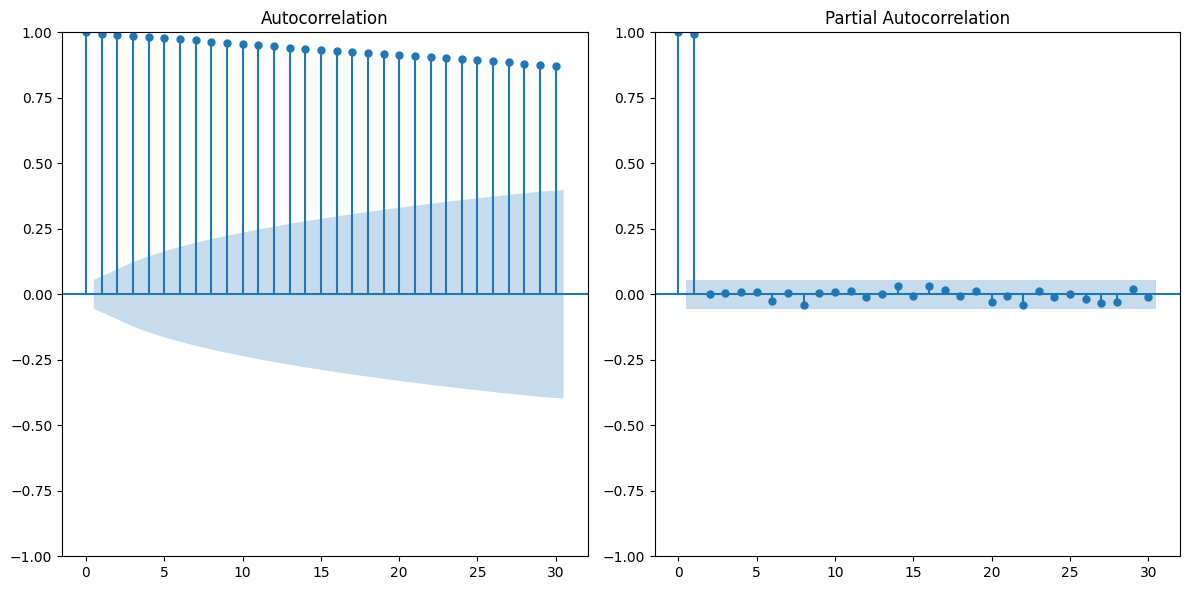

In [19]:
plt.figure(figsize=(12, 6))

# ACF
plt.subplot(1, 2, 1)
plot_acf(AdjClose, ax=plt.gca(), lags=30)
plt.title('Autocorrelation')

# PACF
plt.subplot(1, 2, 2)
plot_pacf(AdjClose, ax=plt.gca(), lags=30, method='ywm')
plt.title('Partial Autocorrelation')

plt.tight_layout()
plt.show()

2.6 결과를 해석하세요.

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

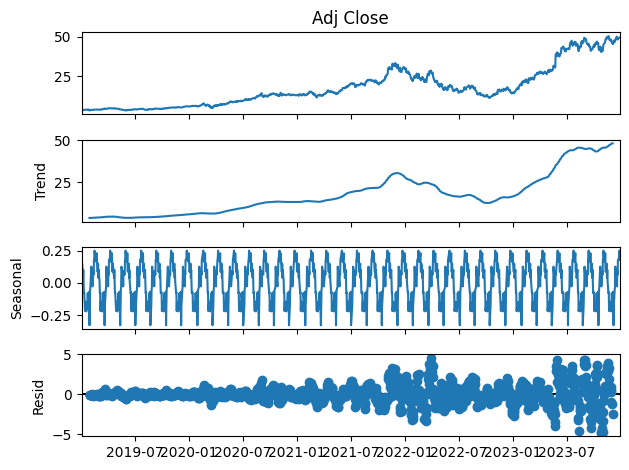

In [21]:
result = seasonal_decompose(AdjClose, model='additive', period=36)

result.plot()
plt.show()

2.8 위 결과를 해석하세요.

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

**차분이란** t시점의 값에서 t-1시점의 값을 빼 이어진 데이터들의 차이를 구하는 것이다. 차분을 하면 값의 차이는 평균이 일정하기 때문에 정상성을 띤다. 한번의 차이를 구하는 1차 차분을 해도 정상성을 띠지 않는다면, 1차 차분값을 다시 차분하는 것을 2차 차분을 한다. 그 이상의 차분은 가능하지만 거의 모든 데이터가 2차 차분으로 정상성을 띤다.

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [22]:
AdjClose_diff = AdjClose.diff().dropna()

# ADF 검정 수행
adf_result = adfuller(AdjClose_diff)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -9.918217286974803
p-value: 3.039746965421937e-17


- ADF Statistic이 약 -9.92로 매우 작은 값이 나와 안정적인 패턴을 가진다.
- p-value가 매우 낮은 값을 나타내 귀무 가설을 기각할 수 있다.

따라서 정상성을 띤다고 할 수 있다.

2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

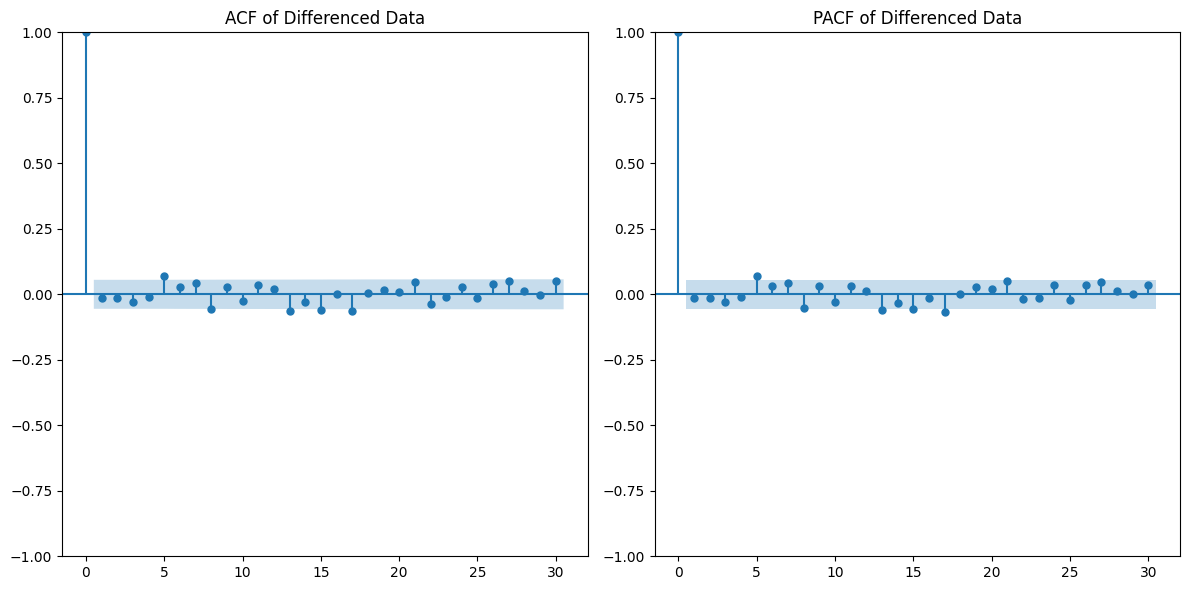

In [23]:
plt.figure(figsize=(12, 6))

# ACF
plt.subplot(1, 2, 1)
plot_acf(AdjClose_diff, ax=plt.gca(), lags=30)
plt.title('ACF of Differenced Data')

# PACF
plt.subplot(1, 2, 2)
plot_pacf(AdjClose_diff, ax=plt.gca(), lags=30, method='ywm')
plt.title('PACF of Differenced Data')

plt.tight_layout()
plt.show()

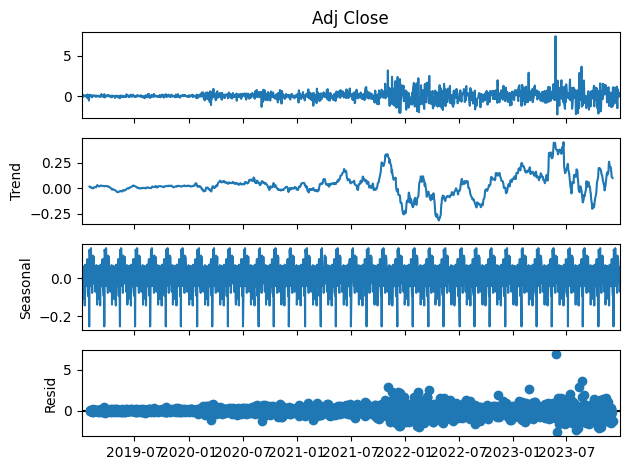

In [24]:
result = seasonal_decompose(AdjClose_diff, model='additive', period=36)

result.plot()
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [29]:
nv['Adj Close_diff'] = nv['Adj Close'].diff()

Date
2019-01-02 00:00:00    3.378322
2019-01-03 00:00:00    3.174216
2019-01-04 00:00:00    3.377578
2019-01-07 00:00:00     3.55639
2019-01-08 00:00:00    3.467852
Name: Adj Close, dtype: object


In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
nv['Adj Close_diff']

Date
2019-01-02         NaN
2019-01-03   -3.760181
2019-01-04    1.450996
2019-01-07   -0.078880
2019-01-08    0.674103
                ...   
2023-12-22   -1.075882
2023-12-26   -0.547943
2023-12-27    0.099625
2023-12-28    0.428375
2023-12-29   -1.046036
Name: Adj Close_diff, Length: 1258, dtype: float64

In [39]:
exog_data = nv[['Volume']].iloc[1:]

model = SARIMAX(nv['Adj Close_diff'].iloc[1:], order=(3, 0, 0), exog=exog_data)  #위에서 차분을 미리 했으므로 차분 값은 0으로 설정
model_fit = model.fit()


model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Adj Close_diff   No. Observations:                 1257
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -1240.564
Date:                Tue, 08 Oct 2024   AIC                           2491.127
Time:                        14:50:06   BIC                           2516.810
Sample:                             0   HQIC                          2500.779
                               - 1257                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume      1.046e-10   2.31e-11      4.539      0.000    5.95e-11     1.5e-10
ar.L1         -0.0135   2.28e-21  -5.95e+18      0.000      -0.014      -0.014
ar.L2         -0.0133   3.35e-21  -3.98e+18      0.000      -0.013      -0.013
ar.L3         -0.0272   5.18e-22  -5.25e+19      0.000      -0.027      -0.027
sigma2         0.4224   5.45e-20   7.75e+18      0.000       0.422       0.422
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12155.90
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              19.87   Skew:                             1.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


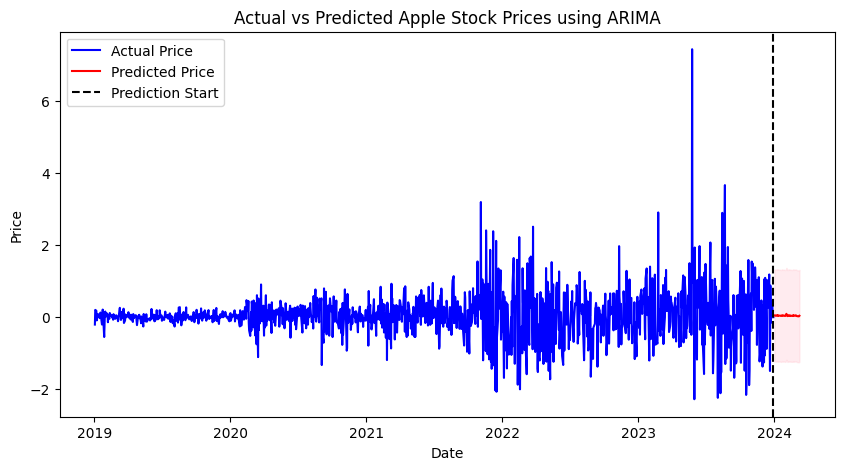

In [42]:
#예측 수행(50일, 200일해도 달라지지 않았음 ㅠ)
forecast_result = model_fit.get_forecast(steps=50, exog=exog_data[-50:])
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

#예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(nv.index, nv['Adj Close_diff'], label='Actual Price', color='blue')
plt.plot(pd.date_range(start=nv.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=nv.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=nv.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted Apple Stock Prices using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [43]:
#실제 데이터 가져오기
actual_data_last_50 = fdr.DataReader('NVDA', '2024-01-01', '2024-03-01')
actual_last_50 = actual_data_last_50[['Close']]

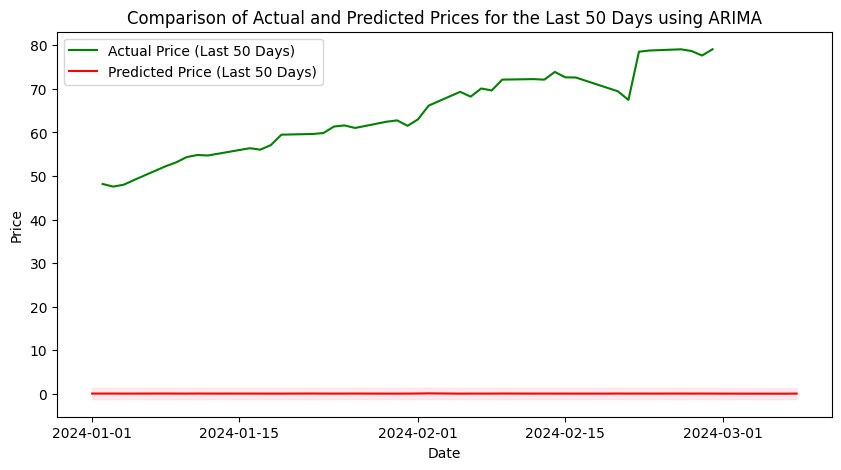

In [46]:
#실제 데이터와 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(actual_last_50.index, actual_last_50['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(pd.date_range(start=nv.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price (Last 50 Days)', color='red')
plt.fill_between(pd.date_range(start=nv.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

ARIMA에서는 성능이 왠지는 모르겠으나 잘 안 나와서 이정도만 하고 넘어가겠습니다. 밑에서 진행할 Prophet 모형의 경우 예측이 제대로 진행되어 추세를 예측하고자 단기적 예측이라 할 수 있는 50일이 아닌 향후 200일을 예측하였습니다.

### Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [ ]:
from prophet import Prophet

In [ ]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###


ticker = 'AAPL'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함

[*********************100%%**********************]  1 of 1 completed


In [ ]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

00:06:19 - cmdstanpy - INFO - Chain [1] start processing
00:06:19 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

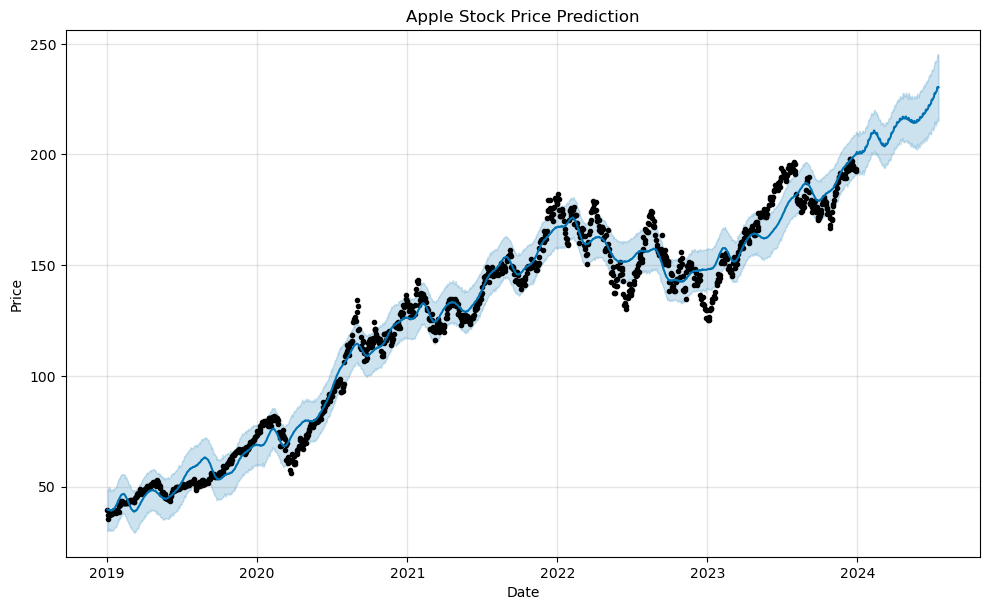

In [ ]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

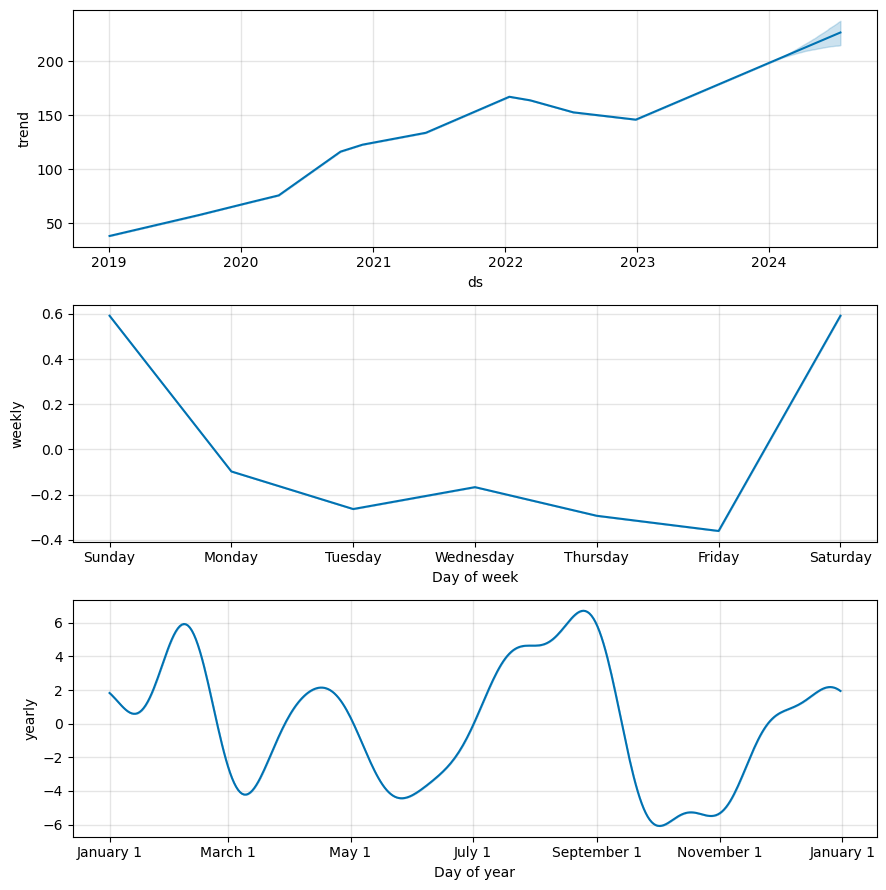

In [ ]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [ ]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

[*********************100%%**********************]  1 of 1 completed


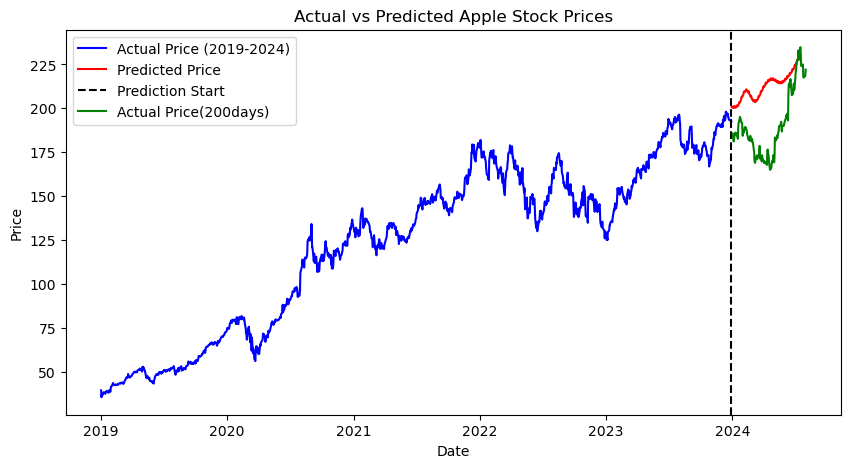

In [ ]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다.

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다.

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.